<a href="https://colab.research.google.com/github/jhonatanvelez1319/Analisis-de-sentimiento/blob/main/TP01/Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reto: Sugerir una manera de implementar inteligencia artificial (IA) para procesar los comentarios de nuestros clientes e
identificar tendencias, problemas comunes, características elogiadas y áreas de mejora.

### Importacion de librerias

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [4]:
# Inicialización
RANDOM_SEED = 42
MAX_LEN = 200
BATCH_SIZE = 16
NCLASSES = 2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Carga de datos

In [5]:
data_model=pd.read_csv('/content/drive/MyDrive/IA_OFFCORSS/IMDB Dataset SPANISH.csv', index_col=0)
# Eliminar las columnas 'review_en' y 'sentiment'
data_model = data_model.drop(columns=['review_en', 'sentiment'])
data= pd.read_parquet('/content/drive/MyDrive/IA_OFFCORSS/IA.parquet')
data_model

,review_es,sentimiento
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...
49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,Voy a tener que estar en desacuerdo con el com...,negativo


In [6]:
# Reajustar dataset
data_model['label'] = (data_model['sentimiento'] == 'positivo').astype(int)
data_model.head()

,review_es,sentimiento,label
0,Uno de los otros críticos ha mencionado que de...,positivo,1
1,Una pequeña pequeña producción.La técnica de f...,positivo,1
2,Pensé que esta era una manera maravillosa de p...,positivo,1
3,"Básicamente, hay una familia donde un niño peq...",negativo,0
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,1


In [7]:
# TOKENIZACIÓN
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [8]:
# Ejemplo tokenización
sample_txt = 'Realmente me encanta esta pelicula !'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  Realmente me encanta esta pelicula !
Tokens:  ['Realmente', 'me', 'encanta', 'esta', 'peli', '##cula', '!']
Tokens numéricos:  [6311, 1129, 6623, 1359, 4264, 8186, 1127]


In [9]:
# Codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=10,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [11]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'Realmente', 'me', 'encanta', 'esta', 'peli', '##cula', '!', '[SEP]', '[PAD]']
tensor([   4, 6311, 1129, 6623, 1359, 4264, 8186, 1127,    5,    1])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0])


In [12]:
# CREACIÓN DATASET
class IMDBDataset(Dataset):

    def __init__(self, review_es, labels, tokenizer, max_len):
        self.review_es = review_es
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.review_es)

    def __getitem__(self, item):
        review_es = str(self.review_es[item])
        label = self.labels[item]
        encoding = tokenizer.encode_plus(
            review_es,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_es': review_es,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [13]:
# Data loader
def data_loader(df, tokenizer, max_len, batch_size):
    dataset = IMDBDataset(
        review_es=df.review_es.to_numpy(),
        labels=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    return DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4)

In [14]:
df_train, df_test = train_test_split(data_model, test_size=0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
# EL MODELO!
class BETOSentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(BETOSentimentClassifier, self).__init__()
        self.beto = AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=n_classes)
        self.drop = nn.Dropout(p=0.4)

    def forward(self, input_ids, attention_mask):
        outputs = self.beto(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return outputs.logits

In [16]:
model = BETOSentimentClassifier(NCLASSES)
model = model.to(device)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# ENTRENAMIENTO
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [19]:
# Entrenamiento!!!

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

Entrenamiento: Loss: 0.31415010454542935, accuracy: 0.8679
Validación: Loss: 0.27268747157752515, accuracy: 0.8894000000000001

Epoch 2 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.17719659644002095, accuracy: 0.94255
Validación: Loss: 0.3370679393015802, accuracy: 0.8948

Epoch 3 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.10585922352599446, accuracy: 0.9726750000000001
Validación: Loss: 0.5013919135316275, accuracy: 0.899

Epoch 4 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.06355613449439407, accuracy: 0.9856250000000001
Validación: Loss: 0.5560135904685128, accuracy: 0.8977

Epoch 5 de 5
------------------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Entrenamiento: Loss: 0.039446550141111945, accuracy: 0.9918
Validación: Loss: 0.596899464560626, accuracy: 0.9015000000000001



In [21]:
#from sklearn.externals import joblib
import joblib
joblib.dump(model, '/content/drive/MyDrive/IA_OFFCORSS/sentiment_model.joblib')

['/content/drive/MyDrive/IA_OFFCORSS/sentiment_model.joblib']

### Analisis exploratorio de los datos

In [22]:
data['store'].value_counts()

store
T036    449
T074    391
T094    352
T042    341
FN60    337
       ... 
FN43     22
FN42     15
FN41     10
FN39      2
FN40      1
Name: count, Length: 65, dtype: int64

In [23]:
# Se analiza si hay valores de fila vacias en todas las columnas.
data.isnull().sum()

# Analizo las filas donde la columna answer esta vacia.
empty= data[data['answer'].isna()]
empty['store'].value_counts()
#empty


store
T036    33
T042    23
T020    23
T041    21
T037    18
T060    17
FN60    16
T074    16
T046    15
FN87    15
FN64    15
T040    14
FN70    13
FN66    13
FN76    13
FN67    13
T059    13
T050    13
T079    12
T082    12
T051    11
FN81    11
FN52    10
FN84    10
FN61    10
FN90    10
FN89     9
FN49     9
T086     8
FN93     8
FN73     8
T038     8
FN82     7
FN71     7
FN86     7
FN78     7
T034     6
FN96     6
FN48     6
FN91     5
FN74     5
T058     4
FN59     4
FN98     4
FN75     4
FN50     3
FN54     3
FN47     3
FN56     3
FN65     2
FN92     1
FN77     1
Name: count, dtype: int64

### Prepocesamiento de los datos

- Hay 528 filas de la columna answer vacias.
- Se conforma un dataframe sin estas filas vacias para posterior analisis con el modelo

In [24]:
# Posteriormente se analizan y eliminan las filas con las columnas vacias
data_clean = data.dropna(subset=['answer'])

# Normalizacion del texto para que todas las letras sean en minuscula y poder asegurar la consistencia de los datos
data_clean['answer'] = data_clean['answer'].str.lower()

data_clean

<ipython-input-24-4c620c262196>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['answer'] = data_clean['answer'].str.lower()


,store,assigned_at,answer
0,FN60,2023-02-20 12:25:30.652022,"todo lo hacen perfecto,, gracias por su atención"
1,FN54,2023-02-20 17:10:31.230531,ya no ay probadores
2,T060,2023-02-21 18:55:32.949118,excelente servicio
3,FN88,2023-02-24 16:25:54.015137,buen servicio
4,T036,2023-02-21 19:25:33.154527,el personal disperso y eso que estaba solo el ...
...,...,...,...
9365,T074,2023-02-11 13:40:30.901471,continúen con la calidad actual y diseños de l...
9366,T051,2023-02-20 18:10:31.484063,"todo muy lindo, innovador 💯"
9367,FN66,2023-02-17 16:40:31.949883,mala la atencion del personal
9368,FN76,2023-01-12 19:55:30.869511,gracias


### Analisis de sentimientos

In [25]:
# Preprocesamiento de los datos de `data_clean`
data_clean['label'] = 0  # Inicializa la columna `label` con ceros

class IMDBDatasetNew(Dataset):
    def __init__(self, reviews, tokenizer, max_len):
        self.reviews = reviews
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        encoding = self.tokenizer.encode_plus(
            review,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'review': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

def data_loader_new(df, tokenizer, max_len, batch_size):
    dataset = IMDBDatasetNew(
        reviews=df.answer.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=4)

new_data_loader = data_loader_new(data_clean, tokenizer, MAX_LEN, BATCH_SIZE)

def classify_comments(model, data_loader, device):
    model = model.eval()
    comments = []
    labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            labels.extend(preds)
            comments.extend(batch['review'])
    return comments, labels

comments, labels = classify_comments(model, new_data_loader, device)

# Convertir los labels de tensores a una lista de enteros
labels = [label.item() for label in labels]

# Asignar las etiquetas a la columna `label` en `data_clean`
data_clean['label'] = labels

# Mostrar el DataFrame con la nueva columna `label`
data_clean

<ipython-input-25-928e40256b01>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['label'] = 0  # Inicializa la columna `label` con ceros
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument

,store,assigned_at,answer,label
0,FN60,2023-02-20 12:25:30.652022,"todo lo hacen perfecto,, gracias por su atención",1
1,FN54,2023-02-20 17:10:31.230531,ya no ay probadores,1
2,T060,2023-02-21 18:55:32.949118,excelente servicio,1
3,FN88,2023-02-24 16:25:54.015137,buen servicio,1
4,T036,2023-02-21 19:25:33.154527,el personal disperso y eso que estaba solo el ...,0
...,...,...,...,...
9365,T074,2023-02-11 13:40:30.901471,continúen con la calidad actual y diseños de l...,1
9366,T051,2023-02-20 18:10:31.484063,"todo muy lindo, innovador 💯",1
9367,FN66,2023-02-17 16:40:31.949883,mala la atencion del personal,0
9368,FN76,2023-01-12 19:55:30.869511,gracias,1


In [26]:
data_clean['sentimiento'] = data_clean['label'].apply(lambda x: 'positivo' if x == 1 else 'negativo')
data_clean

<ipython-input-26-ea40c82da4aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['sentimiento'] = data_clean['label'].apply(lambda x: 'positivo' if x == 1 else 'negativo')


,store,assigned_at,answer,label,sentimiento
0,FN60,2023-02-20 12:25:30.652022,"todo lo hacen perfecto,, gracias por su atención",1,positivo
1,FN54,2023-02-20 17:10:31.230531,ya no ay probadores,1,positivo
2,T060,2023-02-21 18:55:32.949118,excelente servicio,1,positivo
3,FN88,2023-02-24 16:25:54.015137,buen servicio,1,positivo
4,T036,2023-02-21 19:25:33.154527,el personal disperso y eso que estaba solo el ...,0,negativo
...,...,...,...,...,...
9365,T074,2023-02-11 13:40:30.901471,continúen con la calidad actual y diseños de l...,1,positivo
9366,T051,2023-02-20 18:10:31.484063,"todo muy lindo, innovador 💯",1,positivo
9367,FN66,2023-02-17 16:40:31.949883,mala la atencion del personal,0,negativo
9368,FN76,2023-01-12 19:55:30.869511,gracias,1,positivo


### Visualización

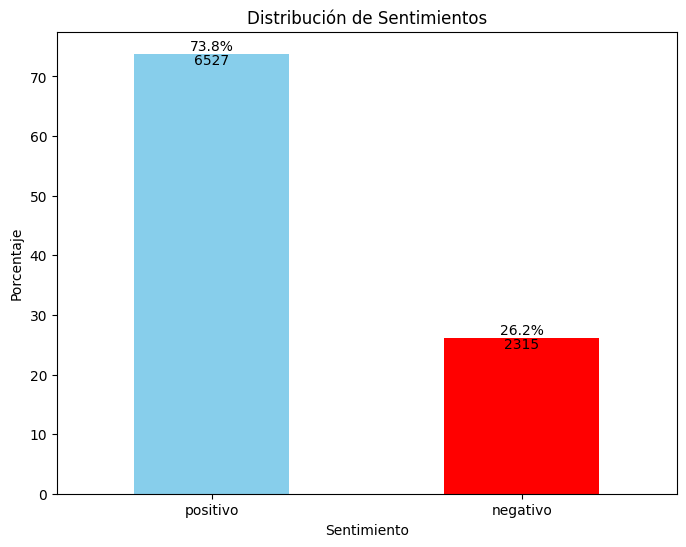

In [27]:
# Calcular los porcentajes y las cantidades exactas de cada valor en la columna 'sentimiento'
sentimiento_counts = data_clean['sentimiento'].value_counts(normalize=True) * 100
sentimiento_counts_exact = data_clean['sentimiento'].value_counts()

# Crear un gráfico de barras
plt.figure(figsize=(8, 6))

# Definir colores
colors = ['red' if index == 'negativo' else 'skyblue' for index in sentimiento_counts.index]

# Graficar las barras con colores personalizados
sentimiento_counts.plot(kind='bar', color=colors)

# Añadir títulos y etiquetas
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)

# Mostrar los porcentajes encima de las barras
for index, value in enumerate(sentimiento_counts):
    plt.text(index, value + 0.5, f'{value:.1f}%', ha='center')

# Mostrar las cantidades exactas dentro de las barras
for index, count in enumerate(sentimiento_counts_exact):
    plt.annotate(f'{count}', xy=(index, sentimiento_counts[index]), ha='center', va='top')

# Mostrar el gráfico
plt.show()


In [28]:
# Filtrar el DataFrame para obtener solo las filas con sentimiento negativo
data_negativo = data_clean[data_clean['sentimiento'] == 'negativo']
data_negativo

,store,assigned_at,answer,label,sentimiento
4,T036,2023-02-21 19:25:33.154527,el personal disperso y eso que estaba solo el ...,0,negativo
7,T051,2023-02-24 16:40:52.064979,nada,0,negativo
13,FN70,2023-02-25 16:55:32.171592,"los asesores de campanario popayan, miran a la...",0,negativo
15,T074,2023-02-26 11:10:31.730250,"yo no compre en esa tienda de bogotá, vivo en ...",0,negativo
19,FN86,2023-02-26 14:10:33.053438,super servicio,0,negativo
...,...,...,...,...,...
9327,FN70,2023-02-16 12:10:30.955537,todo super,0,negativo
9333,FN71,2023-02-09 15:40:31.819254,la marca como tal ha decaído mucho en la ciuda...,0,negativo
9343,T036,2023-02-17 12:40:30.859928,me encantan los diseños. sería bueno revisar l...,0,negativo
9358,T099,2023-02-19 16:55:33.652627,ya voy por la segunda generación comprando e...,0,negativo


In [40]:
# Filtrar el DataFrame para obtener solo las filas donde 'answer' contiene la palabra 'super'
negativo_filtrado = data_negativo[data_negativo['answer'].str.contains('super', case=False, na=False)]
negativo_filtrado

In [30]:
# Filtrar el DataFrame para obtener solo las filas con sentimiento negativo
data_positivo = data_clean[data_clean['sentimiento'] == 'positivo']
data_positivo

,store,assigned_at,answer,label,sentimiento
0,FN60,2023-02-20 12:25:30.652022,"todo lo hacen perfecto,, gracias por su atención",1,positivo
1,FN54,2023-02-20 17:10:31.230531,ya no ay probadores,1,positivo
2,T060,2023-02-21 18:55:32.949118,excelente servicio,1,positivo
3,FN88,2023-02-24 16:25:54.015137,buen servicio,1,positivo
5,T094,2023-02-23 18:40:54.110973,muy buenas ofertas,1,positivo
...,...,...,...,...,...
9364,T040,2023-02-18 20:25:36.551522,"muy buenos los descuentos,gracias",1,positivo
9365,T074,2023-02-11 13:40:30.901471,continúen con la calidad actual y diseños de l...,1,positivo
9366,T051,2023-02-20 18:10:31.484063,"todo muy lindo, innovador 💯",1,positivo
9368,FN76,2023-01-12 19:55:30.869511,gracias,1,positivo


In [34]:
data_negativo['store'].value_counts()

store
T036    139
T094    132
T074    117
T060    100
T041     78
       ... 
T102      6
FN43      4
FN98      4
FN42      4
FN40      1
Name: count, Length: 63, dtype: int64

In [35]:
data_positivo['store'].value_counts()

store
T036    277
FN60    260
T074    258
T042    246
T094    220
       ... 
T020     16
FN98     15
FN42     11
FN41     10
FN39      2
Name: count, Length: 64, dtype: int64

### Deteccion de temas

In [39]:
import nltk
from nltk.util import ngrams
from collections import Counter
nltk.download('punkt')
# Función para generar n-gramas
def generate_ngrams(text, n):
    tokens = nltk.word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

# Generar 4-gramas para cada respuesta y agregarlos a una lista
all_4grams = []
for answer in data_negativo['answer']:
    all_4grams.extend(generate_ngrams(answer, 3))

# Contar la frecuencia de cada 4-grama
ngram_freq = Counter(all_4grams)

# Convertir el resultado a un DataFrame para una mejor visualización
ngram_df = pd.DataFrame(ngram_freq.items(), columns=['4-grama', 'Frecuencia'])

# Mostrar los 10 4-gramas más comunes
ngram_df.sort_values(by='Frecuencia', ascending=False).head(11)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,4-grama,Frecuencia
673,"(en, la, tienda)",68
1119,"(me, gustaría, que)",37
3724,"(atención, al, cliente)",31
435,"(la, tienda, de)",30
3254,"(la, calidad, de)",27
1340,"(de, la, tienda)",27
629,"(la, atención, de)",25
447,"(de, las, prendas)",23
1640,"(la, ropa, de)",22
4361,"(un, poco, más)",18


# Analisis

El modelo obtuvo excelentes resultados durante su entrenamiento, logrando clasificar correctamente la mayoría de los comentarios, como se aprecia en las matrices de confusión. El modelo fue entrenado con un dataset de Kaggle que contiene reseñas de usuarios sobre películas, adaptado al español. Aunque intenté encontrar un dataset específico de reseñas de tiendas para evitar sesgos, no tuve éxito.

Sin embargo, al clasificar la base de datos de la compañía, hay coherencia en la clasificación del algoritmo en varios casos siendo importante recalcar que ningún algoritmo es perfecto y que tal vez se podria tener una mejor clasificacion entrenando el modelo con un dataset de reseñas de clientes de , incluso aunque tedioso se deberia etiquetar el dataset entregado en futuros proyectos para tal vez tener resultaos mas consistentes.

Al visualizar la clasificacion de los comentarios se puede observar que el 82.7% de los comentarios de los clientes de offcorss fueron positivos y solo el 17.3% fueron negativos, resaltando que en general los clientes estan satisfechos,